In [1]:
import numpy as np
from run_evolution_spins import folder_evol
import matplotlib.pyplot as plt
import yastn
import yastn.tn.mps as mps
from scripts_spins.operators import Ln


In [2]:
g = 1 / 5
L0 = 0
D0 = 64
m = 0.318 * g   # [0 * g, 0.1 * g, 0.318 * g, 1 * g]
N, a = (200, 0.5)
# Nas =  [(100, 1.0), (200, 0.5), (400, 0.25)]
folder = folder_evol(g, m, L0, a, N, 1, 1, D0)

In [4]:
ops = yastn.operators.Spin12(sym='U1')
t = 30
data = np.load(folder / f"state_t={t:0.2f}.npy", allow_pickle=True).item()
psi = mps.load_from_dict(ops.config, data["psi"])
psi0 = psi.copy()

In [5]:
n0, n1 = N // 2, N // 2 + 1
I, Sp, Sm = ops.I(), ops.sp(), ops.sm()
d = {0: Sp @ Sm, 1: Sm @ Sp}

terms  = [mps.Hterm(1 / (4 * a), [n0 - 1, n0], [Sp, Sm])]
terms += [mps.Hterm(1 / (4 * a), [n0 - 1, n0], [Sm, Sp])]
terms += [mps.Hterm(1 / (2 * a), [n0, n1], [Sp, Sm])]
terms += [mps.Hterm(1 / (2 * a), [n0, n1], [Sm, Sp])]
terms += [mps.Hterm(1 / (4 * a), [n1, n1 + 1], [Sp, Sm])]
terms += [mps.Hterm(1 / (4 * a), [n1, n1 + 1], [Sm, Sp])]
terms += [mps.Hterm(m, [n0], [d[n0 % 2]])]
terms += [mps.Hterm(m, [n1], [d[n1 % 2]])]
HI = mps.product_mpo(I, N)
H = mps.generate_mpo(HI, terms)

t = 0
Ln0 = Ln(n0, N, t=t, L0=L0, a=a, v=1, Q=1, ops=ops)
Ln1 = Ln(n1, N, t=t, L0=L0, a=a, v=1, Q=1, ops=ops)
e0 = a * g * g / 2

OO = H + e0 * (Ln0 @ Ln0 + Ln1 @ Ln0)

OO.canonize_(to='last', normalize=False)
OO.truncate_(to='first', opts_svd={'tol': 1e-12}, normalize=False)


3.8980992911072334e-15

In [6]:
times = np.linspace(0, 20, 101)
res = []
for step in mps.tdvp_(psi, OO, times, dt=1/8, method='2site',
                      opts_svd={"D_total": D0}, yield_ti=True):
    res.append(abs(mps.vdot(psi0, psi)))

Text(0.5, 1.0, 'OO is local energy operator in the center; T=30; N=200; a=0.5')

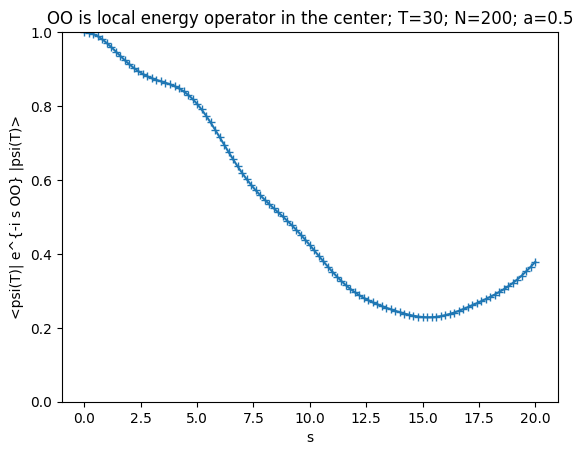

In [8]:
plt.plot(times, res, '-+')
plt.ylim([0, 1])
plt.xlabel("s")
plt.ylabel("<psi(T)| e^{-i s OO} |psi(T)>")
plt.title("OO is local energy operator in the center; T=30; N=200; a=0.5")

Text(0.5, 1.0, 'OO is local energy operator in the center; T=30; N=200; a=0.5')

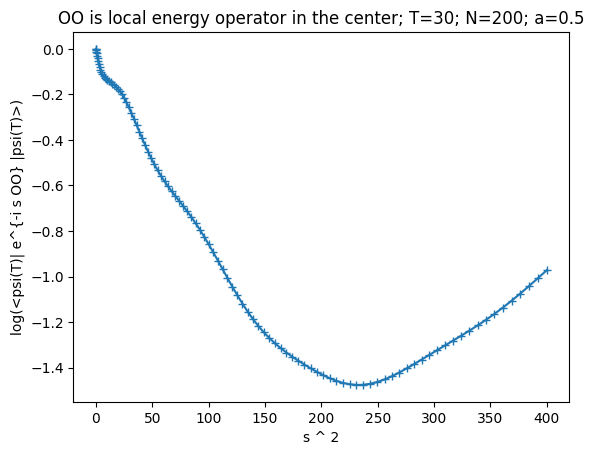

In [10]:
plt.plot(times ** 2, np.log(res), '-+')
plt.xlabel("s ^ 2")
plt.ylabel("log(<psi(T)| e^{-i s OO} |psi(T)>)")
plt.title("OO is local energy operator in the center; T=30; N=200; a=0.5")
